## Import module

In [3]:
import os
import sys
from collections import defaultdict
import numpy as np
import pandas as pd
import glob
from scipy import stats
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, MonthLocator, DayLocator, MONDAY, YEARLY
os.chdir('../results/')

## Plot function

In [4]:
def StandardPlot(ax, fontsize=12, grid=True, ticks=True, left=True, right=True, top=True, bottom=True):
    font_label = {'family': 'arial', 'size': fontsize}
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('arial') for label in labels]
    if grid == True:
        ax.xaxis.grid(linestyle='--', c='grey',
                      alpha=0.4, linewidth=0.3, zorder=0)
        ax.yaxis.grid(linestyle='--', c='grey',
                      alpha=0.4, linewidth=0.3, zorder=0)
    if ticks == True:
        ax.tick_params(axis='x', direction='out',
                       color='black', labelsize=fontsize, pad=3)
        ax.tick_params(axis='y', direction='out',
                       color='black', labelsize=fontsize, pad=3)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    return ax

def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

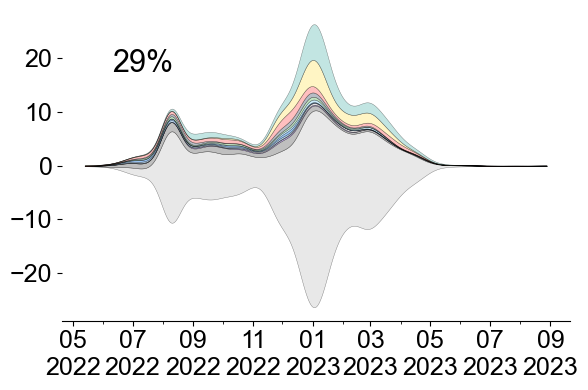

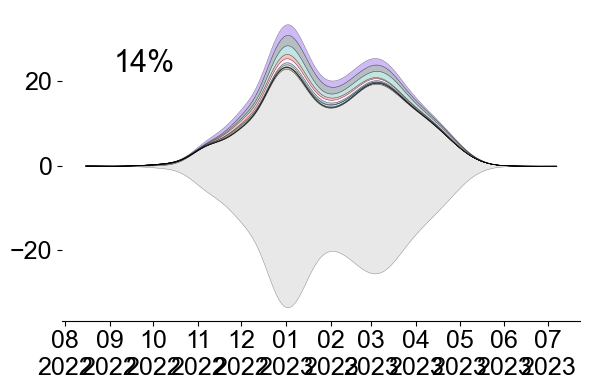

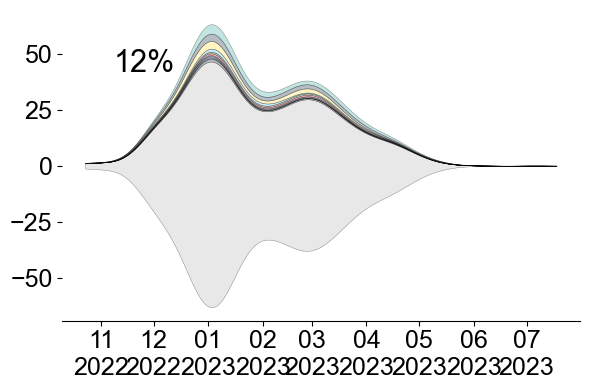

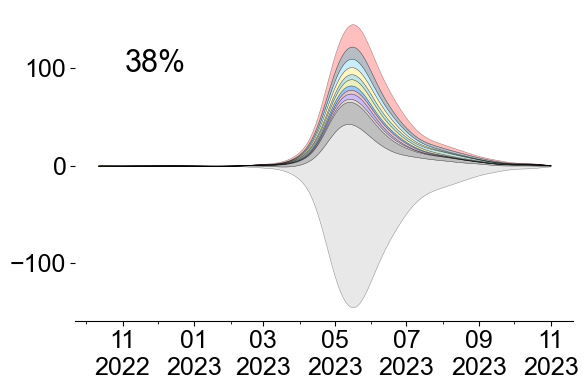

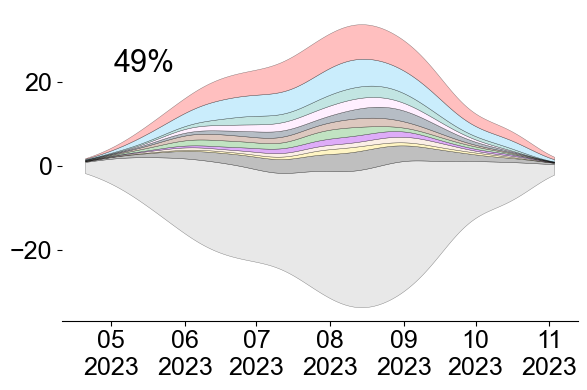

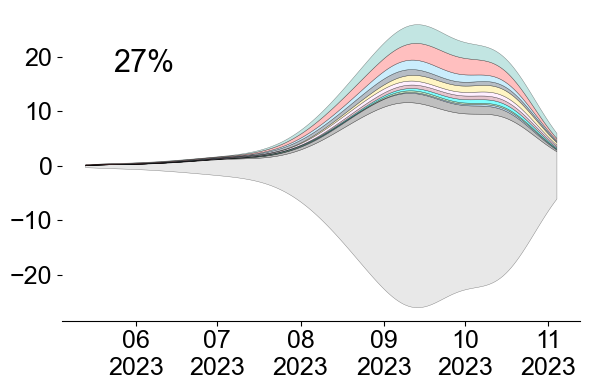

In [5]:
dominant_Omicron_sublineages = ['BA.5','BF.7', 'DY','XBB','EG.5','HK']
color_dct = {
        'Hong Kong':'#9F79EE',
        'Taiwan':'blue',
        'Macau':'yellow',
        'Japan':'#6E7C8D',
        'South Korea':'#86CCC6',
        'USA':'#FF8080',
        'Canada':'#FFE1FF',
        'France':'#78AEDE',
        'Singapore':'#FFEC8B',
        'Australia':'#97DCFA',
        'Germany':'#84C887',
        'Israel':'#708090',
        'United Kingdom':'#3A8EED',
        'Ireland':'#CDC9C9',
        'South Africa':'#938964',
        'Italy':'#A1D99B',
        'Austria':'#BC9281',
        'Luxembourg':'#BF5AF2',
        'Denmark':'#F9E0CE',
        'Malaysia':'#CF8CA1',
        'New Zealand':'#00FFFF',
        'India':'#D7E27F',
        'Indonesia':'#CDB7B5',
        'Netherlands':'#D1EEEE',
        'Thailand':'#CD96CD',
        'Vietnam':'#DDA0DD',
        'Philippines':'#B0E2FF',
        'Russia':'#7AC5CD',
        'Cambodia':'#BCD2EE',
        'United Arab Emirates':'#938964',
        'Others':'grey',
        'domestic':'lightgrey'
    }
for lineage in dominant_Omicron_sublineages:
    df_cn = pd.read_csv('../data/cn_meta_unredund.csv')
    df_cn_i = df_cn[df_cn['Omicron sublineages'].isin([lineage])]
    df_cn_i.insert(1,'year_month', ['%s-%s' % ( i.split('-')[0],i.split('-')[1]) for i in df_cn_i['Collection date']])
    df = pd.read_csv('mutnet/Overseas_%s_network.csv' % lineage)
    df_trans = pd.read_csv('Overseas_trans/Overseas_%s.csv' % lineage,index_col = 0).sort_values(by='sum', ascending=False)
    export_prop = round(len(df)*100/len(df_cn_i))
    t_lst = sorted(df['t_date'].unique())
    t_lst = [str(i.date()) for i in pd.date_range(start=t_lst[0], end=t_lst[-1], freq='D')]            
    export_top10 = df_trans.index.tolist()[:10]+['Others']
    export_top10 = export_top10[::-1]
    df['country'] = [i  if i in export_top10 else 'Others' for  i in df['s_country']]
    c_lst = df.country.unique().tolist()
    df_trans = df_trans.reindex(c_lst)
    c_t_dct = {i:{j:0 for j in t_lst} for i in c_lst}
    for x,y in df['source'].groupby([df['country'],df['t_date']]):
        c_t_dct[x[0]][x[1]] = len(y)
    c_dct = defaultdict(list)
    for c in c_lst:
        for t in t_lst:
            c_dct[c].append(c_t_dct[c][t])
    for t in t_lst:
        df_cn_t = df_cn_i[df_cn_i['Collection date'].isin([t])]
        df_t = df[df['t_date'].isin([t])]
        c_dct['domestic'].append(len(df_cn_t)-len(df_t))
    export_top10.insert(0,'domestic')
    plt.rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(figsize=(6, 4))
    fontsize = 18
    c_dct = dict(sorted(c_dct.items(),key = lambda x:export_top10.index(x[0])))
    color_lst =[color_dct[i] for i in export_top10]
    colors = [color_dct[i] for i in c_dct.keys()]
    Y = np.array(list(c_dct.values()))
    X = []
    for n,t in enumerate(t_lst):
        X.append(n+1)
    grid = np.linspace(X[0],X[-1] , num=len(X))
    y_0,m_0,d_0 = int(t_lst[0].split('-')[0]),int(t_lst[0].split('-')[1]),int(t_lst[0].split('-')[2])
    x_ticks = [datetime.datetime.fromordinal(int(datetime.datetime(y_0,m_0,d_0).toordinal()+ (i-1))) for i in grid]
    y_smoothed = [gaussian_smooth(X, y_, grid, 10) for y_ in Y]
    ax.stackplot(x_ticks, y_smoothed, 
                 alpha = 0.5,linewidth = 0.3,edgecolor = 'k', colors = color_lst,
                 baseline="sym",
                 labels=export_top10
                )
    ax = StandardPlot(ax,fontsize=fontsize,left=False,right= False,top = False,grid = False,ticks = True)
    ax.text(0.1,0.8,r'%s%%' % export_prop, size=fontsize+4, fontdict={'family': 'arial','fontweight':'bold'},transform=ax.transAxes)     
    monthdays = MonthLocator()
    ax.xaxis.set_minor_locator(monthdays)
    ax.xaxis.set_major_formatter(DateFormatter('%m\n%Y')) 
    ax.set(xlabel=None)
    plt.tight_layout()